# Соревнование по распознаванию фамилий


Ваша команда разрабатывает продукт для распознавания документов. В качестве одной из подзадач, возникших в этом проекте, нужно построить классификатор, который по фрагменту текста сможет определить, насколько вероятно, что этот текст - чья-то фамилия.

Для оценки качества решено использовать площадь под ROC-кривой (AUC), учитывайте это при подготовке прогноза на тестовой выборке.

В этом соревновании вам предстоит решить обычную задачу бинарной классификации, но признаки вам понадобится извлечь из примеров самостоятельно. В вашем распоряжении обучающая выборка, тестовая (на ней нужно спрогнозировать ответы) и пример файла с прогнозами. В примере прогнозов есть некоторый подвох, который специально может ввести вас в заблуждение, но если вы помните, как вычисляется ROC-AUC, вы на него не попадётесь :)

Описание файлов:

linear_train.txt - обучающая выборка

linear_test.txt - тестовая выборка

linear_ans_example.txt - пример файла с прогнозами

Точность разметки данных
Разметка датасета была частично автоматизирована, поэтому некоторые "фамилии" из выборки могут вас очень удивить. К сожалению, с этой проблемой часто приходится иметь дело при работе с "грязными" данными. В рамках этого задания вам нужно считать разметку выборки идеальной. С одной стороны, вам не нужно думать, как вычистить выборку. С другой стороны, это приведет к тому, что какие-то действительно хорошие идеи признаков могут не заработать.

## 1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns        
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report,roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import xgboost as xgb

import seaborn as sns
sns.set(font_scale = 1.5)

## 2. Чтение файлов

In [2]:
surname_test = pd.read_csv('linear_test.txt', header = None)
surname_data = pd.read_csv('linear_train.txt', header = None)

In [3]:
surname_data.rename(columns={0: "surname", 1: "answer"}, inplace=1)
surname_test.rename(columns={0: "surname"}, inplace=1)
surname_data.head()

,surname,answer
0,Аалтонен,1
1,Аар,0
2,Аарон,0
3,ААРОН,0
4,Аарона,0


**Проверим распределение классов**

In [4]:
surname_data.answer.value_counts()

0    90770
1    10638
Name: answer, dtype: int64

**Видно дисбаланс классов, поэтому предлагается использовать ROC AUC в качестве метрики качества модели.**

## 3. Построение признаков

**Необходимо задать функции, которые помогут в построении признаков**

In [5]:
okonchanie = ['ин', 'ын','ов','ев','ан','ой','их','ых', 'ен','ина', 'ына','ова','ева','ких','ая','чик','ски','дзе','ина',
             'шин', 'кин', 'нко', 'йко', 'ко', 'кий', 'кая', 'тти','ез','ес','лло','сон','ерг','ис', 'ом','ерс','рс',
             'ной','ным','вой','вым','ном','ой','ым','ом','кой','ким','им', 'сон','он','сен','ен','ия','онс','нсу','нс',
             'ана','она','оне','на','мон','он','оне','не', 'на','ва', 'ера','ну',
             'ом','ов','на','ва','ну','ра','ой','ер','ым','са','он','ин','не','ву','ие','та','ка','су','ев','ру',
             'ова','ном','вым','ера','ина','ром','она','сон','ние','вой','нов','ков','ева','ову','кий','ону','еру','ого','сон','тон']
        
glacnie = ['у', 'е', 'а', 'ы', 'о', 'э', 'я', 'и', 'ю', 'ё' ]
soglas = ['й','ц','к','н','г','ш','щ','з','х','ф','в','п','р','л','д','ж','ч','с','м','т','б']
znak = ['ь', 'ъ']
okonch4 = ['овым','ером','оном','овой','ение','ский','кого','енко','кова','сона',
           'нова','иным','аном','ская','анов','тона','евым','ской','сону','рова']
okonch1 = ['а','м','у','е','н','в','и','й','ы','о','р', 'с']


suf = ['ен','ов','ер','ко','ан','ск','ин','он','со','то', 'ар','ро', 'ор']


In [6]:
   def shrift(st):         # Как написано слово (маленькими буквами, большими буквами, с большой буквы)
    if st.istitle():
        return 1
    if st.isupper():
        return 2
    else: return 0
    
def kol_glas(st):  # Количество гласных букв в слове
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] in glacnie:
            k+=1
    return k   

def kol_soglas(st):   # Количество согласных букв в слове
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] in soglas:
            k+=1
    return k 

def znaki(st):   # Количество твердых и мягких знаков
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] in znak:
            k+=1
    return k 

def a(st):   # Количество буквы "а"
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'а':
            k+=1
    return k 

def povtor(st):   # Количество повторяющихся подряд двух букв
    k = 0
    st = st.lower()
    for i in range(len(st)-1):
        if st[i] == st[i+1]:
            k+=1
    return k 

def ya(st):   # Количество буквы "я"
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'я':
            k+=1
    return k 

def povtor3(st):  # Количество повторяющихся подряд трех букв
    k = 0
    st = st.lower()
    for i in range(len(st)-2):
        if st[i] == st[i+1]==st[i+2]:
            k+=1
    return k 

def v(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'в':
            k+=1
    return k

def n(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'н':
            k+=1
    return k

def m(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'м':
            k+=1
    return k

def o(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'о':
            k+=1
    return k

def e(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'е':
            k+=1
    return k

def i(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'и':
            k+=1
    return k

def t(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'т':
            k+=1
    return k

def r(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'р':
            k+=1
    return k

def s(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'с':
            k+=1
    return k

def l(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'л':
            k+=1
    return k

def chh(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'щ':
            k+=1
    return k

def fe(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'ф':
            k+=1
    return k

def ee(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'э':
            k+=1
    return k

def k(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'к':
            k+=1
    return k

def p(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'п':
            k+=1
    return k

def u(st):
    k = 0
    st = st.lower()
    for i in range(len(st)):
        if st[i] == 'у':
            k+=1
    return k

In [7]:
surname_data['kol_bukw'] = [len(element) for element in surname_data['surname']] 

# Cтолбцы с последними буквами
surname_data['okon1'] = [element[-1:].lower() for element in surname_data.surname]
surname_data['okon2'] = [element[-2:].lower() for element in surname_data['surname']]
surname_data['okon3'] = [element[-3:].lower() for element in surname_data['surname']]
surname_data['okon4'] = [element[-4:].lower() for element in surname_data.surname]
surname_data['okon1_bool'] = np.where(surname_data.okon1.isin(okonch1),1,0)
surname_data['okon2_bool'] = np.where(surname_data.okon2.isin(okonchanie),1,0)
surname_data['okon3_bool'] = np.where(surname_data.okon3.isin(okonchanie),1,0)
surname_data['okon4_bool'] = np.where(surname_data.okon4.isin(okonch4),1,0)

# Суффикс слова 
surname_data['sufix'] = [element[-4:-2].lower() for element in surname_data['surname']]
surname_data['sufix_bool'] = np.where(surname_data.sufix.isin(suf),1,0)

# Шрифт и спец.символы
surname_data['probel'] = [element.count(' ') for element in surname_data.surname]
surname_data['tire'] = [element.count('-') for element in surname_data.surname]
surname_data['shrift'] = [shrift(element) for element in surname_data.surname]
surname_data['symbols'] = [element.count("«")+element.count("»")+element.count('“')+element.count('”')+ \
                           element.count(" ") for element in surname_data.surname]
# Буквенный состав слова
surname_data['glasnie'] = [kol_glas(element) for element in surname_data.surname]
surname_data['soglasnie'] = [kol_soglas(element) for element in surname_data.surname]
surname_data['znaki'] = [znaki(element) for element in surname_data.surname]
surname_data['povtorenie'] = [povtor(element) for element in surname_data.surname]
surname_data['povtorenie3'] = [povtor3(element) for element in surname_data.surname]

# Отдельные буквы
surname_data['ya'] = [ya(element) for element in surname_data.surname]
surname_data['a'] = [a(element) for element in surname_data.surname]
surname_data['v'] = [v(element) for element in surname_data.surname]
surname_data['n'] = [n(element) for element in surname_data.surname]
surname_data['m'] = [m(element) for element in surname_data.surname]

surname_data['o'] = [o(element) for element in surname_data.surname]
surname_data['e'] = [e(element) for element in surname_data.surname]
surname_data['i'] = [i(element) for element in surname_data.surname]
surname_data['t'] = [t(element) for element in surname_data.surname]
surname_data['r'] = [r(element) for element in surname_data.surname]
surname_data['s'] = [s(element) for element in surname_data.surname]
surname_data['l'] = [l(element) for element in surname_data.surname]

surname_data['chh'] = [chh(element) for element in surname_data.surname]
surname_data['fe'] = [fe(element) for element in surname_data.surname]
surname_data['ee'] = [ee(element) for element in surname_data.surname]

surname_data['k'] = [k(element) for element in surname_data.surname]
surname_data['p'] = [p(element) for element in surname_data.surname]
surname_data['u'] = [u(element) for element in surname_data.surname]

In [8]:
surname_data.head()

,surname,answer,kol_bukw,okon1,okon2,okon3,okon4,okon1_bool,okon2_bool,okon3_bool,...,t,r,s,l,chh,fe,ee,k,p,u
0,Аалтонен,1,8,н,ен,нен,онен,1,1,0,...,1,0,0,1,0,0,0,0,0,0
1,Аар,0,3,р,ар,аар,аар,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Аарон,0,5,н,он,рон,арон,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,ААРОН,0,5,н,он,рон,арон,1,1,0,...,0,1,0,0,0,0,0,0,0,0
4,Аарона,0,6,а,на,она,рона,1,1,1,...,0,1,0,0,0,0,0,0,0,0


In [9]:
surname_data.describe(percentiles=[])

,answer,kol_bukw,okon1_bool,okon2_bool,okon3_bool,okon4_bool,sufix_bool,probel,tire,shrift,...,t,r,s,l,chh,fe,ee,k,p,u
count,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,...,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000
mean,0.104903,8.450152,0.774702,0.338859,0.111934,0.029692,0.195882,0.001045,0.008126,0.540342,...,0.476935,0.547215,0.393677,0.352773,0.024278,0.059926,0.031743,0.393135,0.236835,0.244488
std,0.306430,2.873555,0.417780,0.473324,0.315287,0.169737,0.396880,0.037406,0.093012,0.657531,...,0.648098,0.641459,0.607149,0.544090,0.154679,0.249623,0.177829,0.570076,0.463004,0.471954
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,33.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000,...,4.000000,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,4.000000,3.000000,4.000000


**Аналогично обработаем данные тестовой выборки**

In [10]:
surname_test['kol_bukw'] = [len(element) for element in surname_test['surname']] 

# Cтолбцы с последними буквами
surname_test['okon1'] = [element[-1:].lower() for element in surname_test.surname]
surname_test['okon2'] = [element[-2:].lower() for element in surname_test['surname']]
surname_test['okon3'] = [element[-3:].lower() for element in surname_test['surname']]
surname_test['okon4'] = [element[-4:].lower() for element in surname_test.surname]
surname_test['okon1_bool'] = np.where(surname_test.okon1.isin(okonch1),1,0)
surname_test['okon2_bool'] = np.where(surname_test.okon2.isin(okonchanie),1,0)
surname_test['okon3_bool'] = np.where(surname_test.okon3.isin(okonchanie),1,0)
surname_test['okon4_bool'] = np.where(surname_test.okon4.isin(okonch4),1,0)

# Суффикс слова 
surname_test['sufix'] = [element[-4:-2].lower() for element in surname_test['surname']]
surname_test['sufix_bool'] = np.where(surname_test.sufix.isin(suf),1,0)

# Шрифт и спец.символы
surname_test['probel'] = [element.count(' ') for element in surname_test.surname]
surname_test['tire'] = [element.count('-') for element in surname_test.surname]
surname_test['shrift'] = [shrift(element) for element in surname_test.surname]
surname_test['symbols'] = [element.count("«")+element.count("»")+element.count('“')+element.count('”')+\
                           element.count(" ") for element in surname_test.surname]
# Буквенный состав слова
surname_test['glasnie'] = [kol_glas(element) for element in surname_test.surname]
surname_test['soglasnie'] = [kol_soglas(element) for element in surname_test.surname]
surname_test['znaki'] = [znaki(element) for element in surname_test.surname]
surname_test['povtorenie'] = [povtor(element) for element in surname_test.surname]
surname_test['povtorenie3'] = [povtor3(element) for element in surname_test.surname]

# Отдельные буквы
surname_test['ya'] = [ya(element) for element in surname_test.surname]
surname_test['a'] = [a(element) for element in surname_test.surname]
surname_test['v'] = [v(element) for element in surname_test.surname]
surname_test['n'] = [n(element) for element in surname_test.surname]
surname_test['m'] = [m(element) for element in surname_test.surname]

surname_test['o'] = [o(element) for element in surname_test.surname]
surname_test['e'] = [e(element) for element in surname_test.surname]
surname_test['i'] = [i(element) for element in surname_test.surname]
surname_test['t'] = [t(element) for element in surname_test.surname]
surname_test['r'] = [r(element) for element in surname_test.surname]
surname_test['s'] = [s(element) for element in surname_test.surname]
surname_test['l'] = [l(element) for element in surname_test.surname]

surname_test['chh'] = [chh(element) for element in surname_test.surname]
surname_test['fe'] = [fe(element) for element in surname_test.surname]
surname_test['ee'] = [ee(element) for element in surname_test.surname]

surname_test['k'] = [k(element) for element in surname_test.surname]
surname_test['p'] = [p(element) for element in surname_test.surname]
surname_test['u'] = [u(element) for element in surname_test.surname]

In [11]:
surname_test.head()

,surname,kol_bukw,okon1,okon2,okon3,okon4,okon1_bool,okon2_bool,okon3_bool,okon4_bool,...,t,r,s,l,chh,fe,ee,k,p,u
0,Аалто,5,о,то,лто,алто,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,ААР,3,р,ар,аар,аар,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Аара,4,а,ра,ара,аара,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Ааре,4,е,ре,аре,ааре,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Аарон,5,н,он,рон,арон,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


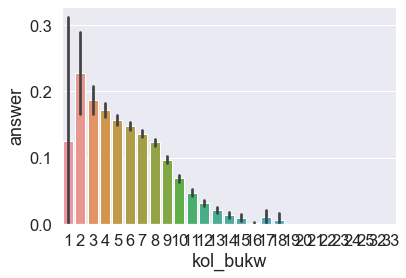

In [38]:
sns.barplot(surname_data.kol_bukw,surname_data.answer)

## 4. Задача целевого значения и признаков

In [12]:
X, y =  surname_data.drop('answer', axis=1).select_dtypes(include = ['float64', 'int64']),\
        surname_data['answer']

**Разделим обучающую выборку еще раз на две для тренировки и проверки качества**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

## 5. Построение модели

**Сначала построим модель с базовыми параметрами**

In [14]:
model = XGBClassifier(scoring= 'roc_auc')
model.fit(X_train, y_train.values.ravel())

y_pred_train = model.predict(X_train)
#print (classification_report(y_train, y_pred_train))

y_pred = model.predict(X_test)
#print (classification_report(y_test, y_pred))

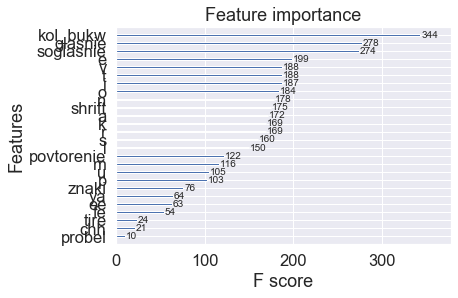

In [15]:
xgb.plot_importance(model)

In [16]:
y_pred = model.predict_proba(X_test)[:,1]

**Оценим точность по ROC AUC**

In [17]:
roc_auc_score(y_test, y_pred)

0.8682365116208582

## 6. Подбор оптимальных параметров модели

In [18]:
model = XGBClassifier()
model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [19]:
params = {
        'min_child_weight': [1, 3, 6],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
        'max_depth': [ 6, 8, 10],
        'n_estimators': [ 100, 150, 200],
        'learning_rate': [ 0.001, 0.01, 0.1, 0.2, 0.3],
        'colsample_bylevel' : [0.5, 0.7, 1],
        'colsample_bytree': [0.7, 1],
        'gamma':[0,1,5,10]
        }

In [22]:
clf = RandomizedSearchCV(model, params, n_jobs=-1, cv=5, scoring='roc_auc', verbose=3, refit=True, n_iter=15)
clf

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_co...
                   iid='warn', n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.5, 0.7, 1],
                                        'colsample_bytree': [0.7, 1],
                         

In [23]:
clf.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  9.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_co...
                   iid='warn', n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.5, 0.7, 1],
                                        'colsample_bytree': [0.7, 1],
                         

**Лучшие параметры классификатора**

In [24]:
clf.best_params_

{'subsample': 0.7,
 'n_estimators': 200,
 'min_child_weight': 6,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 5,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.5}

In [25]:
best_clf = clf.best_estimator_
best_clf

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.7, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=None)

**Определим точность предсказания по ROC AUC**

In [26]:
y_pred = best_clf.predict_proba(X_test)[:,1]

In [27]:
roc_auc_score(y_test, y_pred)

0.8659360717415528

## 7. Получение результатов

In [29]:
X = surname_test.select_dtypes(include = ['float64', 'int64'])

In [32]:
y_predicted_prob = best_clf.predict_proba(X)[:,1]
y_predicted_prob

array([0.28273404, 0.21129891, 0.33489004, ..., 0.11182114, 0.01351884,
       0.00971121], dtype=float32)

In [33]:
y = pd.DataFrame(y_predicted_prob, index =None)
y = y.rename(columns={0: "Answer"})
y = y.rename_axis('Id')
y

,Answer
Id,
0,0.282734
1,0.211299
2,0.334890
3,0.442119
4,0.325426
...,...
188915,0.014959
188916,0.126358
188917,0.111821


Сохраним в файл csv.

In [ ]:
y.to_csv('surname_solverxgb.csv')